In [2]:
# Import PySpark
from pyspark.sql import SparkSession
#Create SparkSession
spark = SparkSession.builder.appName('SparkByExamples.com').getOrCreate()
from pyspark.sql.functions import regexp_replace, col, when

C:\Users\LENOVO\anaconda3\Lib\site-packages\pyspark\broadcast.py:38: DeprecationWarning: typing.io is deprecated, import directly from typing instead. typing.io will be removed in Python 3.12.
  from typing.io import BinaryIO  # type: ignore[import]


In [3]:
from pyspark.sql import SparkSession

# Initialize a Spark session
spark = SparkSession.builder.appName("Transaction Analysis").getOrCreate()

# Load the CSV file into a Spark DataFrame
df_spark = spark.read.csv("transactionrecord.csv", header=True, inferSchema=True)
df_spark.show(5)

+-------------+---------+---------+--------------------+----------------+-----+--------+----------+--------------+
|TransactionNo|     Date|ProductNo|         ProductName|Product_category|Price|Quantity|CustomerNo|       Country|
+-------------+---------+---------+--------------------+----------------+-----+--------+----------+--------------+
|       581482|12/9/2019|    22485|Set Of 2 Wooden M...|             0ca|21.47|      12|     17490|United Kingdom|
|       581475|12/9/2019|    22596|Christmas Star Wi...|             0ca|10.65|      36|     13069|United Kingdom|
|       581475|12/9/2019|    23235|Storage Tin Vinta...|             0ca|11.53|      12|     13069|United Kingdom|
|       581475|12/9/2019|    23272|Tree T-Light Hold...|             0ca|10.65|      12|     13069|United Kingdom|
|       581475|12/9/2019|    23239|Set Of 4 Knick Kn...|             0ca|11.94|       6|     13069|United Kingdom|
+-------------+---------+---------+--------------------+----------------+-----+-

In [4]:
df_spark = df_spark.withColumn(
    "CustomerNo", when(col("CustomerNo").isNull() | (col("CustomerNo") == 'NA'), '-1').otherwise(col("CustomerNo"))
)

# 1.1.2: Process the text in productName column to only leave alphabet characters
df_spark = df_spark.withColumn(
    "productName_process", 
    regexp_replace(col("ProductName"), "[^A-Za-z]", "")
)

# Show the first 5 rows of the DataFrame with the new column
df_spark.select("ProductName", "productName_process").show(5, truncate=False)

+-----------------------------------+-------------------------------+
|ProductName                        |productName_process            |
+-----------------------------------+-------------------------------+
|Set Of 2 Wooden Market Crates      |SetOfWoodenMarketCrates        |
|Christmas Star Wish List Chalkboard|ChristmasStarWishListChalkboard|
|Storage Tin Vintage Leaf           |StorageTinVintageLeaf          |
|Tree T-Light Holder Willie Winkie  |TreeTLightHolderWillieWinkie   |
|Set Of 4 Knick Knack Tins Poppies  |SetOfKnickKnackTinsPoppies     |
+-----------------------------------+-------------------------------+
only showing top 5 rows



#### Explanation:

Replacing 'NA' in the CustomerNo column:

We use the when function to check if the CustomerNo is either null or 'NA'. If it is, we replace it with '-1'. Otherwise, we keep the original value using otherwise.
Processing the ProductName column:

We use regexp_replace to remove all non-alphabetic characters ([^A-Za-z]) from the ProductName column, and store the result in a new column called productName_process.
This code will display the original ProductName along with the processed productName_process for the first 5 rows.

### #1.2.1 Calculate the revenue and save it as float

In [5]:
from pyspark.sql.functions import col

# Calculate revenue and cast it to float
df_spark = df_spark.withColumn("Revenue", (col("Price") * col("Quantity")).cast("float"))

# Show the top 5 rows with the new Revenue column
df_spark.select("Date", "Price", "Quantity", "Revenue").show(5, truncate=False)

+---------+-----+--------+-------+
|Date     |Price|Quantity|Revenue|
+---------+-----+--------+-------+
|12/9/2019|21.47|12      |257.64 |
|12/9/2019|10.65|36      |383.4  |
|12/9/2019|11.53|12      |138.36 |
|12/9/2019|10.65|12      |127.8  |
|12/9/2019|11.94|6       |71.64  |
+---------+-----+--------+-------+
only showing top 5 rows



##### 1.2.2 Convert the PySpark DataFrame to a Pandas DataFrame

In [6]:
import pandas as pd

# Convert PySpark DataFrame to Pandas DataFrame
df_pandas = df_spark.toPandas()

# Create a new column 'transaction_date' by converting the 'Date' column to date format
df_pandas['transaction_date'] = pd.to_datetime(df_pandas['Date'], format='%m/%d/%Y')

# Show the top 5 rows of the Pandas DataFrame with the new column
df_pandas[['Date', 'transaction_date', 'Revenue']].head()

,Date,transaction_date,Revenue
0,12/9/2019,2019-12-09,257.640015
1,12/9/2019,2019-12-09,383.399994
2,12/9/2019,2019-12-09,138.360001
3,12/9/2019,2019-12-09,127.800003
4,12/9/2019,2019-12-09,71.639999


##### 1.2.3 Plot the sum of revenue on transaction_date

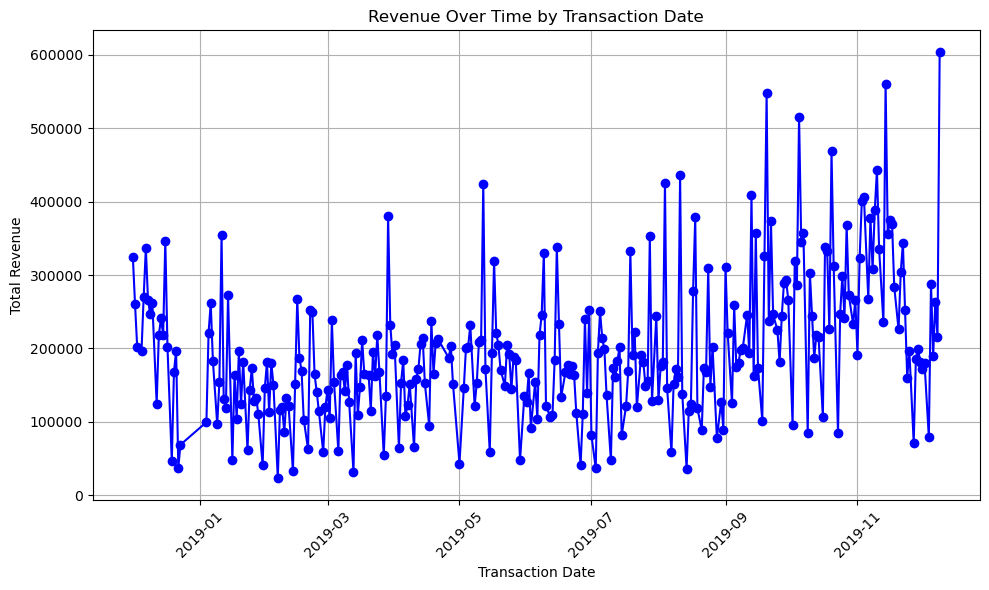

In [7]:
import matplotlib.pyplot as plt

# Group by transaction date and sum the revenue
revenue_by_date = df_pandas.groupby('transaction_date')['Revenue'].sum().reset_index()

# Plot the sum of revenue by transaction date
plt.figure(figsize=(10, 6))
plt.plot(revenue_by_date['transaction_date'], revenue_by_date['Revenue'], marker='o', linestyle='-', color='b')
plt.title('Revenue Over Time by Transaction Date')
plt.xlabel('Transaction Date')
plt.ylabel('Total Revenue')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

#### Explanation:

##### 1.2.1 Revenue Calculation:

We calculate revenue by multiplying Price by Quantity and casting the result as a float.

##### 1.2.2 Transform PySpark to Pandas:

Convert the PySpark DataFrame to a Pandas DataFrame using toPandas().
The transaction_date column is created by converting the Date column to a proper date format (%d/%m/%Y).

##### 1.2.3 Plotting the Revenue:

We group by transaction_date and sum the revenue.

A line plot is created to visualize the total revenue for each transaction date, helping us identify patterns or trends.
Insight:

Once the plot is generated, you can inspect the pattern of revenue over time to find trends like seasonal spikes or drops in sales.

##### 1.3.1 Determine which workday generates the most sales

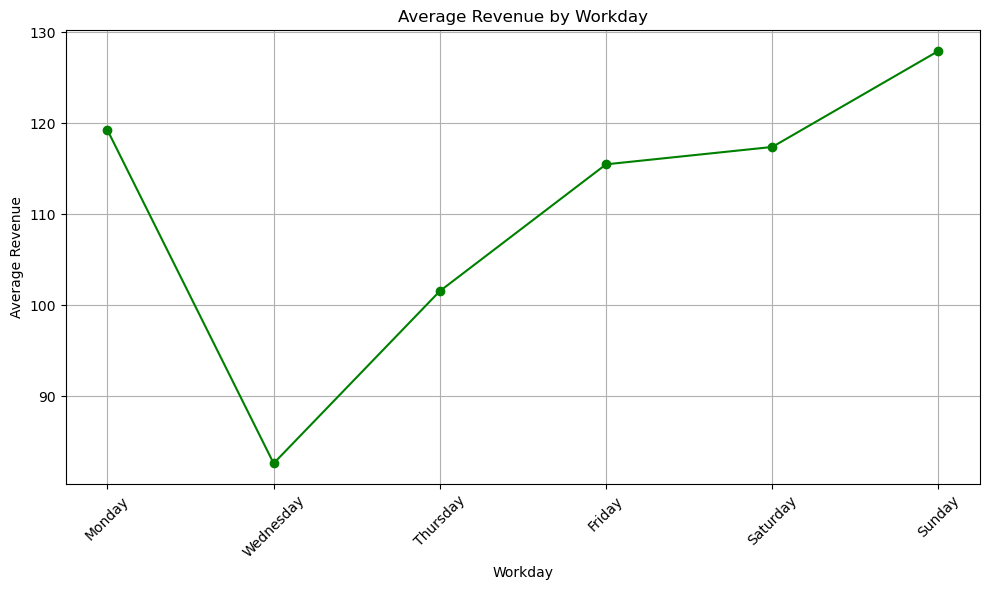

In [8]:
# 1.3.1: Extract the workday from the transaction date (Monday=0, Sunday=6)
df_pandas['weekday'] = df_pandas['transaction_date'].dt.dayofweek

# Group by the weekday and calculate the average revenue
avg_revenue_by_weekday = df_pandas.groupby('weekday')['Revenue'].mean().reset_index()

# Create a mapping for weekday names (optional but for better visualization)
weekday_map = {0: 'Monday', 1: 'Tuesday', 2: 'Wednesday', 3: 'Thursday', 4: 'Friday', 5: 'Saturday', 6: 'Sunday'}
avg_revenue_by_weekday['weekday_name'] = avg_revenue_by_weekday['weekday'].map(weekday_map)

# Plot the average revenue by weekday
plt.figure(figsize=(10, 6))
plt.plot(avg_revenue_by_weekday['weekday_name'], avg_revenue_by_weekday['Revenue'], marker='o', linestyle='-', color='g')
plt.title('Average Revenue by Workday')
plt.xlabel('Workday')
plt.ylabel('Average Revenue')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

##### 1.3.2 Identify the product that contributes the highest revenue and highest sales volume on that workday

In [9]:
# Find the weekday with the highest average revenue
max_revenue_weekday = avg_revenue_by_weekday.loc[avg_revenue_by_weekday['Revenue'].idxmax()]['weekday']

# Filter data for that specific workday
workday_data = df_pandas[df_pandas['transaction_date'].dt.dayofweek == max_revenue_weekday]

# 1. Find the product contributing the highest revenue on that day
highest_revenue_product = workday_data.groupby('productName_process')['Revenue'].sum().reset_index()
highest_revenue_product = highest_revenue_product.sort_values(by='Revenue', ascending=False).iloc[0]

# 2. Find the product with the highest sales volume (Quantity) on that day
highest_volume_product = workday_data.groupby('productName_process')['Quantity'].sum().reset_index()
highest_volume_product = highest_volume_product.sort_values(by='Quantity', ascending=False).iloc[0]

# Output results
highest_revenue_product_name = highest_revenue_product['productName_process']
highest_volume_product_name = highest_volume_product['productName_process']

highest_revenue_product_name, highest_volume_product_name


('WorldWarGlidersAsstdDesigns', 'WorldWarGlidersAsstdDesigns')

##### 1.3.3 Plot top 5 products by revenue and sales volume in general

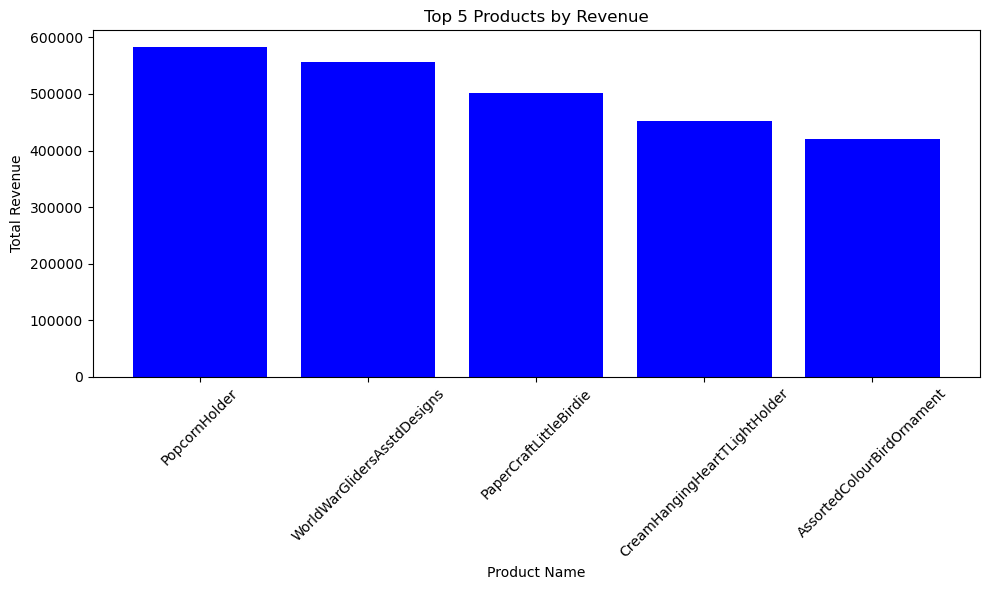

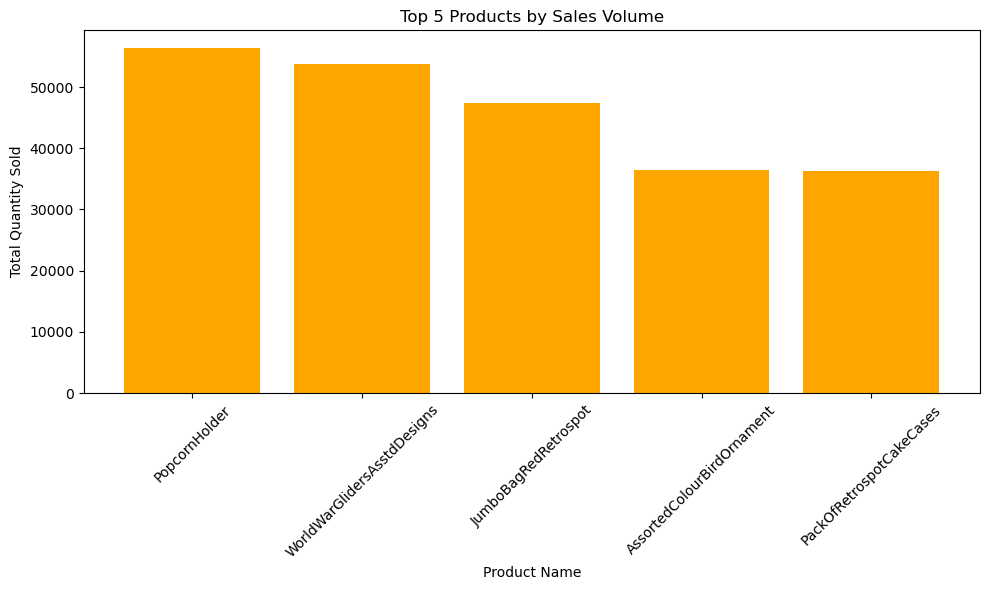

In [10]:
# 1.3.3: Calculate the top 5 products by total revenue
top_5_revenue_products = df_pandas.groupby('productName_process')['Revenue'].sum().reset_index()
top_5_revenue_products = top_5_revenue_products.sort_values(by='Revenue', ascending=False).head(5)

# Plot the top 5 revenue products
plt.figure(figsize=(10, 6))
plt.bar(top_5_revenue_products['productName_process'], top_5_revenue_products['Revenue'], color='blue')
plt.title('Top 5 Products by Revenue')
plt.xlabel('Product Name')
plt.ylabel('Total Revenue')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# 1.3.3: Calculate the top 5 products by total sales volume (Quantity)
top_5_volume_products = df_pandas.groupby('productName_process')['Quantity'].sum().reset_index()
top_5_volume_products = top_5_volume_products.sort_values(by='Quantity', ascending=False).head(5)

# Plot the top 5 products by sales volume
plt.figure(figsize=(10, 6))
plt.bar(top_5_volume_products['productName_process'], top_5_volume_products['Quantity'], color='orange')
plt.title('Top 5 Products by Sales Volume')
plt.xlabel('Product Name')
plt.ylabel('Total Quantity Sold')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

##### Summary of Results:

1.3.1: line chart showing the average revenue by weekday.

1.3.2: The highest_revenue_product_name and highest_volume_product_name will hold the names of the products contributing the most revenue and sales volume on the highest revenue weekday.

1.3.3: Two bar plots show:

Top 5 products contributing the highest revenue in general.
Top 5 products contributing the highest sales volume in general.

This analysis provides a detailed view of how workdays impact sales, and which products are top performers.

##### 1.4.1 

In [11]:
# 1.4.1: Group by country and calculate total revenue
country_revenue = df_pandas.groupby('Country')['Revenue'].sum().reset_index()

# Find the country with the highest revenue
highest_revenue_country = country_revenue.loc[country_revenue['Revenue'].idxmax()]['Country']

# 1.4.2: Filter the data for that country
country_data = df_pandas[df_pandas['Country'] == highest_revenue_country]

# Extract month from the transaction date
country_data['transaction_month'] = country_data['transaction_date'].dt.to_period('M')

# Group by month and calculate total revenue for each month
monthly_revenue = country_data.groupby('transaction_month')['Revenue'].sum().reset_index()

# Find the month with the highest revenue
highest_revenue_month = monthly_revenue.loc[monthly_revenue['Revenue'].idxmax()]['transaction_month']

# Output the results
highest_revenue_country, highest_revenue_month

C:\Users\LENOVO\AppData\Local\Temp\ipykernel_8584\2780043277.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  country_data['transaction_month'] = country_data['transaction_date'].dt.to_period('M')


('United Kingdom', Period('2019-11', 'M'))

##### Explanation:

Step 1: We group the data by Country and calculate the total revenue for each country. The country with the highest revenue is determined using idxmax() on the revenue column.

Step 2: Once the country is identified, we filter the dataset for that country and extract the month from the transaction_date column.

Step 3: We group the data by transaction_month and calculate the total revenue for each month in that country. The month with the highest revenue is identified similarly using idxmax().

Output:
highest_revenue_country: The country with the highest revenue.
highest_revenue_month: The month in that country with the highest revenue.

##### 1.5 

To analyze CustomerNo and their shopping frequency, we need to:

Filter out transactions where the quantity is less than or equal to 0 (as these are non-shopping transactions).
Determine the customer with the highest number of distinct transactions.
Identify the products that this customer typically buys based on the quantity of products purchased.

Steps:

Filter out non-shopping transactions.
Calculate the distinct count of TransactionNo for each customer and find the customer who shops most frequently.
For this customer, determine the products they typically buy based on the quantity of products purchased.

In [12]:
# 1.5.1: Filter out transactions where Quantity <= 0
valid_transactions = df_pandas[df_pandas['Quantity'] > 0]

# 1.5.2: Group by CustomerNo and count distinct TransactionNo for each customer
customer_frequency = valid_transactions.groupby('CustomerNo')['TransactionNo'].nunique().reset_index()

# Find the customer who shops most frequently (highest distinct count of TransactionNo)
most_frequent_customer = customer_frequency.loc[customer_frequency['TransactionNo'].idxmax()]['CustomerNo']

# 1.5.3: Filter the data for this most frequent customer
customer_data = valid_transactions[valid_transactions['CustomerNo'] == most_frequent_customer]

# Group by productName_process and sum the Quantity for each product
customer_favorite_products = customer_data.groupby('productName_process')['Quantity'].sum().reset_index()

# Sort by Quantity to identify the products the customer buys most
customer_favorite_products = customer_favorite_products.sort_values(by='Quantity', ascending=False)

# Output results
most_frequent_customer, customer_favorite_products.head()

('12748',
                 productName_process  Quantity
 1609   VictorianMetalPostcardSpring       595
 1706    WorldWarGlidersAsstdDesigns       480
 1273  RoseScentCandleJewelledDrawer       408
 201         CartoonPencilSharpeners       405
 1483    SmallWhiteRetrospotMugInBox       390)

##### Explanation:

Step 1: We filter out any transactions where Quantity is less than or equal to zero, as these are non-shopping transactions.

Step 2: We group the data by CustomerNo and calculate the distinct count of TransactionNo for each customer using nunique(). The customer with the highest distinct count is identified using idxmax().

Step 3: After identifying the most frequent customer, we filter the data for this customer and group by productName_process to find the total quantity of each product they bought. Sorting by Quantity reveals the products they typically buy.

Output:

most_frequent_customer: The ID of the customer who shops most frequently.

customer_favorite_products.head(): The top products this customer typically buys based on the quantity purchased.

##### 1.6.1
Steps:

Filter the data for transactions where Quantity > 0 to exclude non-shopping transactions.

Group by TransactionNo and aggregate:

product_category into a list.

productName_process into a list.

Remove adjacent duplicates in the aggregated product_category list.

Save the processed DataFrame as df_1 and display the top 10 rows.

In [13]:
import pandas as pd

# 1.6.1: Filter the data where Quantity > 0
filtered_df = df_pandas[df_pandas['Quantity'] > 0]

# Group by TransactionNo and aggregate the product_category and productName_process into lists
basket_level_df = filtered_df.groupby('TransactionNo').agg({
    'Product_category': lambda x: list(x),
    'productName_process': lambda x: list(x)
}).reset_index()




In [14]:
# 1.6.2: Function to remove adjacent duplicates in product_category list
def remove_adjacent_duplicates(category_list):
    if not category_list:  # if list is empty, return it as is
        return category_list
    deduped_list = [category_list[0]]  # initialize with the first element
    for i in range(1, len(category_list)):
        if category_list[i] != category_list[i - 1]:
            deduped_list.append(category_list[i])
    return deduped_list

# Apply the remove_adjacent_duplicates function to the product_category column
basket_level_df['product_category_processed'] = basket_level_df['Product_category'].apply(remove_adjacent_duplicates)

# Save the processed dataframe as 'df_1'
df_1 = basket_level_df[['TransactionNo', 'product_category_processed', 'productName_process']]

# Print the top 10 rows of df_1
df_1.head(10)

,TransactionNo,product_category_processed,productName_process
0,536365,[0ca],"[CreamHangingHeartTLightHolder, WhiteMoroccanM..."
1,536366,[0ca],"[HandWarmerUnionJack, HandWarmerRedRetrospot]"
2,536367,[0ca],"[AssortedColourBirdOrnament, PoppysPlayhouseBe..."
3,536368,[0ca],"[JamMakingSetWithJars, RedCoatRackParisFashion..."
4,536369,[0ca],[BathBuildingBlockWord]
5,536370,[0ca],"[AlarmClockBakelikePink, AlarmClockBakelikeRed..."
6,536371,[0ca],[PaperChainKitSChristmas]
7,536372,[0ca],"[HandWarmerRedRetrospot, HandWarmerUnionJack]"
8,536373,[0ca],"[CreamHangingHeartTLightHolder, WhiteMoroccanM..."
9,536374,[0ca],[VictorianSewingBoxLarge]


Explanation:

Filtering transactions: We filter out the transactions where Quantity is less than or equal to zero (df_pandas[df_pandas['Quantity'] > 0]).

Grouping and aggregating:

We group the filtered DataFrame by TransactionNo and aggregate product_category and productName_process into lists using agg().
lambda x: list(x) is used to convert the grouped product categories and product names into lists.
Removing adjacent duplicates:

We define a function remove_adjacent_duplicates that iterates through each product_category list and removes duplicates in adjacent positions.
Saving the processed DataFrame: The result is saved in a new DataFrame df_1, and we display the top 10 rows.

Output:

df_1 will contain the following columns:
TransactionNo: Transaction number.
product_category_processed: List of product categories with adjacent duplicates removed.
productName_process: List of product names.

##### 1.7.1 Create a new column prod_len
This column will store the length of the product_category_processed list for each transaction.

In [15]:
# 1.7.1: Create the column 'prod_len' to store the length of each product category list
df_1['prod_len'] = df_1['product_category_processed'].apply(len)

# Print the first five rows of df_1
df_1[['TransactionNo', 'product_category_processed', 'prod_len']].head(5)


,TransactionNo,product_category_processed,prod_len
0,536365,[0ca],1
1,536366,[0ca],1
2,536367,[0ca],1
3,536368,[0ca],1
4,536369,[0ca],1


##### 1.7.2 Transform the list in product_category_processed into a path

In [16]:
# Define the data_processing function
def data_processing(df, maxlength=3, minlength=1):
    # 1. Filter the dataframe based on prod_len
    filtered_df = df[(df['prod_len'] >= minlength) & (df['prod_len'] <= maxlength)]
    
    # 2. Create the 'path' column by transforming the product_category_processed
    filtered_df['path'] = filtered_df['product_category_processed'].apply(
        lambda x: 'start > ' + ' > '.join(x) + ' > conversion'
    )
    
    # Return the new dataframe
    return filtered_df

# 3. Apply the data_processing function to df_1 with maxlength = 5 and minlength = 2
df_2 = data_processing(df_1, maxlength=5, minlength=2)

# 4. Print the top 10 rows of df_2
df_2[['TransactionNo', 'product_category_processed', 'prod_len', 'path']].head(10)

C:\Users\LENOVO\AppData\Local\Temp\ipykernel_8584\4155658847.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['path'] = filtered_df['product_category_processed'].apply(


,TransactionNo,product_category_processed,prod_len,path
13,536378,"[0ca, 1ca, 0ca]",3,start > 0ca > 1ca > 0ca > conversion
27,536395,"[0ca, 1ca, 0ca]",3,start > 0ca > 1ca > 0ca > conversion
36,536404,"[0ca, 1ca, 0ca, 4ca, 0ca]",5,start > 0ca > 1ca > 0ca > 4ca > 0ca > conversion
40,536408,"[0ca, 1ca, 0ca]",3,start > 0ca > 1ca > 0ca > conversion
42,536412,"[0ca, 4ca, 0ca]",3,start > 0ca > 4ca > 0ca > conversion
43,536415,"[0ca, 1ca, 0ca]",3,start > 0ca > 1ca > 0ca > conversion
52,536464,"[0ca, 1ca, 0ca]",3,start > 0ca > 1ca > 0ca > conversion
72,536532,"[0ca, 1ca, 0ca]",3,start > 0ca > 1ca > 0ca > conversion
82,536542,"[0ca, 4ca]",2,start > 0ca > 4ca > conversion
83,536544,"[0ca, 1ca, 0ca, 4ca, 0ca]",5,start > 0ca > 1ca > 0ca > 4ca > 0ca > conversion


##### Explanation:
    
1.7.1 (Create prod_len):

We use .apply(len) to find the length of each product_category_processed list and store it in the new column prod_len.
1.7.2 (Create path column):

We define the data_processing function that filters the DataFrame based on the length of prod_len (using the minlength and maxlength parameters).

Inside the function, we apply a transformation to create the path column by prepending "start > " to the list and appending " > conversion". The list is joined using " > " as the separator.

Filtering: The df_2 DataFrame is returned with transactions that have a prod_len between minlength and maxlength. For this example, we set maxlength = 5 and minlength = 2.

Output:

The result (df_2) contains:

TransactionNo: The transaction number.

product_category_processed: The list of processed product categories (with no adjacent duplicates).

prod_len: The length of the list.

path: The transformed path, starting with "start" and ending with "conversion".

##### 1.8.1: Finding transactions that end with specific patterns

In [17]:
# Patterns to search for
patterns = ['0ca', '1ca', '2ca', '3ca', '4ca']

# Create a dictionary to store the count for each pattern
pattern_count = {}

# Loop through each pattern and count the transactions that end with the specified pattern
for pattern in patterns:
    pattern_str = f"{pattern} > conversion"
    pattern_count[pattern_str] = df_2['path'].apply(lambda x: x.endswith(pattern_str)).sum()

# Print the results for 1.8.1
pattern_count


{'0ca > conversion': 3056,
 '1ca > conversion': 26,
 '2ca > conversion': 144,
 '3ca > conversion': 68,
 '4ca > conversion': 198}

##### 1.8.2: Counting patterns within the transactions

In [18]:
# Patterns to search for
pattern_combinations = [
    '0ca > 0ca',
    '0ca > 1ca',
    '0ca > 2ca',
    '0ca > 3ca',
    '0ca > 4ca',
    '0ca > conversion'
]

# Create a dictionary to store the count for each pattern
pattern_combination_count = {}

# Loop through each pattern and count its occurrences in each transaction
for pattern in pattern_combinations:
    pattern_combination_count[pattern] = df_2['path'].apply(lambda x: x.count(pattern)).sum()

# Print the results for 1.8.2
pattern_combination_count


{'0ca > 0ca': 0,
 '0ca > 1ca': 1222,
 '0ca > 2ca': 1137,
 '0ca > 3ca': 343,
 '0ca > 4ca': 1198,
 '0ca > conversion': 3056}

##### 1.8.3: Counting how many times the transactions contain 0ca as part of a sequence

In [19]:
# Count how many times '0ca > ...' appears in the entire dataset
pattern_0ca_count = df_2['path'].apply(lambda x: x.count('0ca > ')).sum()

# Print the result for 1.8.3
pattern_0ca_count


6956

##### 1.8.4: Using the results from 1.8.2 and dividing by the result from 1.8.3

In [20]:
# Use the 6 results from 1.8.2 and divide them by the result from 1.8.3
pattern_sum = sum([count / pattern_0ca_count for count in pattern_combination_count.values()])

# Print the final result for 1.8.4
pattern_sum


1.0

##### Explanation:

1.8.1: We are checking whether the path ends with specific patterns using the endswith() function for each pattern and summing the results across all transactions.

1.8.2: Here, we count how many times each specific pattern occurs in the path. The count() function helps us identify how many times each pattern appears in every transaction.

1.8.3: We count the occurrences of 0ca > ... in the path using count('0ca > '), summing the results for all transactions.

1.8.4: We divide each result from 1.8.2 by the result from 1.8.3 and sum all the resulting values.

##### Output:

1.8.1: A dictionary showing how many transactions end with each pattern.

1.8.2: A dictionary showing how many times each pattern occurs within the transactions.

1.8.3: The total count of occurrences of 0ca > ... in the dataset.

1.8.4: The sum of the results from 1.8.2 divided by the result from 1.8.3.

##### 1.9.1: Building the Transaction-Level Product DataFrame

In [21]:
# Filter out transactions with negative quantities
filtered_df = df_pandas[df_pandas['Quantity'] > 0]

# Get the top 100 products by sum of Quantity
top_products = filtered_df.groupby('productName_process')['Quantity'].sum().nlargest(100).index

# Filter the dataframe to keep only the top 100 products
filtered_df_top = filtered_df[filtered_df['productName_process'].isin(top_products)]

# Pivot to create the transaction-level product dataframe
transaction_product_df = filtered_df_top.pivot_table(
    index='TransactionNo', 
    columns='productName_process', 
    values='Quantity', 
    aggfunc='sum',
    fill_value=0
)

# Print the first few rows of the transaction-level product dataframe
transaction_product_df.head()


productName_process,AgedGlassSilverTLightHolder,AntiqueSilverTLightGlass,AssortedColourBirdOrnament,AssortedColoursSilkFan,AssortedFlowerColourLeis,AsstdDesigndPaperStickers,BaggSwirlyMarbles,BlackRecordCoverFrame,BrocadeRingPurse,BubblegumRingAssorted,...,StrawberryCharlotteBag,SweetheartFairyCakeCases,TeatimeFairyCakeCases,TravelCardWalletKeepCalm,VictorianGlassHangingTLight,VintageSnapCards,WoodenHeartChristmasScandinavian,WoodenStarChristmasScandinavian,WoodlandCharlotteBag,WorldWarGlidersAsstdDesigns
TransactionNo,,,,,,,,,,,,,,,,,,,,,
536365,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
536367,0,0,32,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
536370,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
536371,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
536373,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


##### 1.9.2: Running the Apriori Algorithm (Minimum Support 1.5%)

In [22]:
from mlxtend.frequent_patterns import apriori, association_rules

# Binarize the quantities: Convert quantities to 1 (purchased) or 0 (not purchased)
transaction_product_binary = transaction_product_df.applymap(lambda x: 1 if x > 0 else 0)

# Run the apriori algorithm with minimum support of 1.5%
frequent_itemsets = apriori(transaction_product_binary, min_support=0.015, use_colnames=True)

# Filter itemsets with length of 4 or more items
frequent_itemsets['length'] = frequent_itemsets['itemsets'].apply(lambda x: len(x))
frequent_itemsets = frequent_itemsets[frequent_itemsets['length'] >= 4]

# Print the resulting itemsets
frequent_itemsets.head()


C:\Users\LENOVO\anaconda3\Lib\site-packages\mlxtend\frequent_patterns\fpcommon.py:109: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(


,support,itemsets,length
515,0.015848,"(CharlotteBagSukiDesign, CharlotteBagPinkPolka...",4
516,0.016236,"(WoodlandCharlotteBag, CharlotteBagSukiDesign,...",4
517,0.015654,"(WoodlandCharlotteBag, RedRetrospotCharlotteBa...",4
518,0.016819,"(WoodlandCharlotteBag, CharlotteBagSukiDesign,...",4
519,0.015137,"(JumboBagWoodlandAnimals, JumboBagPinkPolkadot...",4


##### 1.9.3: Apriori with Support >= 1.0% and Lift > 10

In [24]:
# Run the apriori algorithm with support >= 1.0%
frequent_itemsets_1 = apriori(transaction_product_binary, min_support=0.01, use_colnames=True)

# Generate association rules with minimum lift of 10
rules = association_rules(frequent_itemsets_1, metric="lift", min_threshold=10)

# Print the rules with support >= 1.0% and lift > 10
rules.head()


C:\Users\LENOVO\anaconda3\Lib\site-packages\mlxtend\frequent_patterns\fpcommon.py:109: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
0,(RedRetrospotCharlotteBag),(CharlotteBagPinkPolkadot),0.066887,0.048063,0.033767,0.504836,10.503706,0.030552,1.922467,0.969652
1,(CharlotteBagPinkPolkadot),(RedRetrospotCharlotteBag),0.048063,0.066887,0.033767,0.702557,10.503706,0.030552,3.137119,0.950478
2,(CharlotteBagPinkPolkadot),(StrawberryCharlotteBag),0.048063,0.046704,0.024516,0.510094,10.921809,0.022272,1.945876,0.954307
3,(StrawberryCharlotteBag),(CharlotteBagPinkPolkadot),0.046704,0.048063,0.024516,0.524931,10.921809,0.022272,2.003787,0.952947
4,(CharlotteBagSukiDesign),(StrawberryCharlotteBag),0.057054,0.046704,0.026845,0.470522,10.074505,0.024181,1.800443,0.955240


##### 1.9.4: Exploring Different Support / Confidence / Lift Measurements

In [25]:
# Run the apriori algorithm with support >= 2.0%
frequent_itemsets_2 = apriori(transaction_product_binary, min_support=0.02, use_colnames=True)

# Generate association rules with minimum confidence of 0.8
rules_2 = association_rules(frequent_itemsets_2, metric="confidence", min_threshold=0.8)

# Print the resulting rules
rules_2.head()


C:\Users\LENOVO\anaconda3\Lib\site-packages\mlxtend\frequent_patterns\fpcommon.py:109: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
0,"(CharlotteBagSukiDesign, CharlotteBagPinkPolka...",(RedRetrospotCharlotteBag),0.026522,0.066887,0.021282,0.802439,11.997007,0.019508,4.723167,0.941619
1,"(CharlotteBagPinkPolkadot, StrawberryCharlotte...",(RedRetrospotCharlotteBag),0.024516,0.066887,0.021088,0.860158,12.859949,0.019448,6.672641,0.945417
2,"(WoodlandCharlotteBag, CharlotteBagPinkPolkadot)",(RedRetrospotCharlotteBag),0.025551,0.066887,0.021023,0.822785,12.301190,0.019314,5.265426,0.942797
3,"(CharlotteBagSukiDesign, StrawberryCharlotteBag)",(RedRetrospotCharlotteBag),0.026845,0.066887,0.021606,0.804819,12.032593,0.019810,4.780766,0.942186
4,"(JumboBagScandinavianBluePaisley, JumboBagPink...",(JumboBagRedRetrospot),0.024711,0.135326,0.020635,0.835079,6.170879,0.017291,5.242946,0.859179


##### Example 2: Support >= .9% and Lift > 10

In [35]:
# Run the apriori algorithm with support >= 0.9%
frequent_itemsets_3 = apriori(transaction_product_binary, min_support=0.009, use_colnames=True)

# Generate association rules with minimum lift of 10
rules_3 = association_rules(frequent_itemsets_3, metric="lift", min_threshold=12)

# Print the resulting rules
rules_3.head()


C:\Users\LENOVO\anaconda3\Lib\site-packages\mlxtend\frequent_patterns\fpcommon.py:109: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
0,(WoodenHeartChristmasScandinavian),(WoodenStarChristmasScandinavian),0.034802,0.033120,0.025099,0.721190,21.775137,0.023946,3.467877,0.988477
1,(WoodenStarChristmasScandinavian),(WoodenHeartChristmasScandinavian),0.033120,0.034802,0.025099,0.757812,21.775137,0.023946,3.985335,0.986757
2,"(PaperChainKitSChristmas, CakeCasesVintageChri...",(PaperChainKitVintageChristmas),0.017530,0.053044,0.011838,0.675277,12.730614,0.010908,2.916195,0.937891
3,(PaperChainKitVintageChristmas),"(PaperChainKitSChristmas, CakeCasesVintageChri...",0.053044,0.017530,0.011838,0.223171,12.730614,0.010908,1.264718,0.973064
4,"(LunchBagAppleDesign, CharlotteBagSukiDesign)",(CharlotteBagPinkPolkadot),0.015913,0.048063,0.009380,0.589431,12.263812,0.008615,2.318580,0.933311


##### Example 3: Support >= 1.5% and Confidence >= 0.7 and Lift > 15

In [28]:
# Run the apriori algorithm with support >= 1.5%
frequent_itemsets_4 = apriori(transaction_product_binary, min_support=0.015, use_colnames=True)

# Generate association rules with minimum confidence of 0.7 and lift > 15
rules_4 = association_rules(frequent_itemsets_4, metric="confidence", min_threshold=0.7)
rules_4 = rules_4[rules_4['lift'] > 15]

# Print the resulting rules
rules_4.head()

C:\Users\LENOVO\anaconda3\Lib\site-packages\mlxtend\frequent_patterns\fpcommon.py:109: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
1,(WoodenHeartChristmasScandinavian),(WoodenStarChristmasScandinavian),0.034802,0.033120,0.025099,0.721190,21.775137,0.023946,3.467877,0.988477
2,(WoodenStarChristmasScandinavian),(WoodenHeartChristmasScandinavian),0.033120,0.034802,0.025099,0.757812,21.775137,0.023946,3.985335,0.986757
47,"(CharlotteBagSukiDesign, CharlotteBagPinkPolka...",(StrawberryCharlotteBag),0.021282,0.046704,0.015848,0.744681,15.944628,0.014854,3.733742,0.957664
48,"(CharlotteBagSukiDesign, StrawberryCharlotteBa...",(CharlotteBagPinkPolkadot),0.021606,0.048063,0.015848,0.733533,15.262026,0.014810,3.572439,0.955114
51,"(WoodlandCharlotteBag, CharlotteBagSukiDesign,...",(CharlotteBagPinkPolkadot),0.021735,0.048063,0.016236,0.747024,15.542720,0.015192,3.762952,0.956450


##### Summary of Insights:

Support and Lift: Higher lift values indicate stronger associations between products, which are critical in identifying cross-selling opportunities.

Top Products: The top 100 products were considered for this analysis, but changing this could yield different insights based on product popularity.

##### 1.10.1: Building the Customer-Product DataFrame

Filter out transactions with negative quantities.

Keep the top 100 products based on the sum of quantities.

Build a customer-product DataFrame where each row represents a CustomerNo, and productName_process becomes columns with aggregated Quantity as values.

In [29]:
import pandas as pd

# Filter out transactions with negative quantities
filtered_df = df_pandas[df_pandas['Quantity'] > 0]

# Get the top 100 products by sum of Quantity
top_products = filtered_df.groupby('productName_process')['Quantity'].sum().nlargest(100).index

# Filter the dataframe to keep only the top 100 products
filtered_df_top = filtered_df[filtered_df['productName_process'].isin(top_products)]

# Pivot the dataframe to create the customer-product matrix
customer_product_df = filtered_df_top.pivot_table(
    index='CustomerNo', 
    columns='productName_process', 
    values='Quantity', 
    aggfunc='sum',
    fill_value=0
)

# Print the first few rows of the customer-product matrix
customer_product_df.head()


productName_process,AgedGlassSilverTLightHolder,AntiqueSilverTLightGlass,AssortedColourBirdOrnament,AssortedColoursSilkFan,AssortedFlowerColourLeis,AsstdDesigndPaperStickers,BaggSwirlyMarbles,BlackRecordCoverFrame,BrocadeRingPurse,BubblegumRingAssorted,...,StrawberryCharlotteBag,SweetheartFairyCakeCases,TeatimeFairyCakeCases,TravelCardWalletKeepCalm,VictorianGlassHangingTLight,VintageSnapCards,WoodenHeartChristmasScandinavian,WoodenStarChristmasScandinavian,WoodlandCharlotteBag,WorldWarGlidersAsstdDesigns
CustomerNo,,,,,,,,,,,,,,,,,,,,,
12004,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
12008,1,40,0,0,0,0,0,0,0,0,...,0,0,0,0,3,2,0,0,0,0
12025,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
12026,0,0,0,0,0,0,0,0,0,0,...,1,1,1,0,0,0,0,0,1,1
12031,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


##### 1.10.2: Calculating the Pairwise Euclidean Distance on Customer Level

In [30]:
from scipy.spatial.distance import pdist, squareform

# Calculate pairwise Euclidean distance between customers based on product quantities
distance_matrix = pdist(customer_product_df.values, metric='euclidean')

# Convert the pairwise distances into a squareform matrix (N x N matrix)
distance_matrix_square = squareform(distance_matrix)

# Convert the distance matrix into a pandas dataframe for better readability
distance_df = pd.DataFrame(distance_matrix_square, index=customer_product_df.index, columns=customer_product_df.index)

# Print the first few rows of the distance dataframe
distance_df.head()


CustomerNo,12004,12008,12025,12026,12031,12042,12043,12050,12057,12063,...,18269,18270,18272,18274,18276,18277,18281,18282,18283,18287
CustomerNo,,,,,,,,,,,,,,,,,,,,,
12004,0.000000,42.130749,13.152946,10.049876,9.949874,22.068076,19.416488,8.426150,33.852622,8.774964,...,22.516660,14.798649,136.216739,20.000000,48.445846,28.548205,13.228757,14.000000,99.005050,42.649736
12008,42.130749,0.000000,43.474130,41.737274,42.308392,46.130250,44.384682,41.737274,53.656314,42.000000,...,47.853944,43.657760,139.807010,45.683695,45.978256,50.019996,43.150898,43.116122,107.791465,59.816386
12025,13.152946,43.474130,0.000000,15.231546,9.899495,24.859606,19.390719,13.266499,32.326460,14.142136,...,27.820855,18.493242,137.542721,22.869193,49.699095,30.626786,17.262677,17.860571,97.483332,45.144213
12026,10.049876,41.737274,15.231546,0.000000,9.695360,20.542639,21.954498,6.782330,37.080992,6.000000,...,24.698178,13.341664,135.535973,18.947295,48.020829,27.820855,11.575837,12.449900,99.413279,43.011626
12031,9.949874,42.308392,9.899495,9.695360,0.000000,22.181073,20.248457,7.211103,33.985291,7.874008,...,25.219040,14.282857,137.040140,19.621417,48.290786,28.284271,12.649111,13.453624,99.191734,43.588989


##### 1.10.3: Finding the Top 3 Most Similar Customers

In [37]:
# Find the top 3 most similar customers for CustomerNo == 13069
similar_customers_13069 = distance_df.loc['13069'].nsmallest(4).index[1:4]  # Exclude itself

# Find the top 3 most similar customers for CustomerNo == 17490
similar_customers_17490 = distance_df.loc['17490'].nsmallest(4).index[1:4]  # Exclude itself

# Print the most similar customers
print("Top 3 similar customers to CustomerNo 13069:", similar_customers_13069)
print("Top 3 similar customers to CustomerNo 17490:", similar_customers_17490)


Top 3 similar customers to CustomerNo 13069: Index(['15118', '17523', '18179'], dtype='object', name='CustomerNo')
Top 3 similar customers to CustomerNo 17490: Index(['12519', '12582', '12652'], dtype='object', name='CustomerNo')


##### 1.10.4: Recommendations for CustomerNo == 13069

Steps for Recommendation:

Identify Missing Products: First, check which products CustomerNo == 13069 has never purchased by looking at the columns where the quantity is 0.

Find Popular Products Among Similar Customers: Look at the top 3 most similar customers (from 1.10.3) and identify the products they have purchased in large quantities.

Recommend Products: Recommend the products that the similar customers have bought but CustomerNo == 13069 hasn’t.

Logic for the Recommendation System:

Get Products Never Purchased:
Filter out the columns (products) where CustomerNo == 13069 has a quantity of 0.

Look at Similar Customers:
For the top 3 similar customers, look at their purchase history and aggregate their product purchases.

Recommendation:
Recommend products with high quantities purchased by similar customers but have a quantity of 0 for CustomerNo == 13069.

In [40]:
# Step 1: Get products never purchased by CustomerNo 13069
products_never_purchased = customer_product_df.loc['13069'][customer_product_df.loc['13069'] == 0].index

# Step 2: Aggregate product quantities for similar customers
similar_customers_data = customer_product_df.loc[similar_customers_13069]

# Step 3: Sum the quantities of products purchased by the similar customers
similar_customers_products_sum = similar_customers_data[products_never_purchased].sum()

# Step 4: Recommend products with the highest quantities purchased by similar customers
recommended_products = similar_customers_products_sum.nlargest(5)

# Print the recommended products for CustomerNo 13069
print("Recommended products for CustomerNo 13069:", recommended_products)


Recommended products for CustomerNo 13069: productName_process
MiniPaintSetVintage              36
AssortedFlowerColourLeis         24
PackOfRetrospotCakeCases         24
DoughnutLipGloss                 20
PaperChainKitVintageChristmas    18
dtype: int64


##### Recommendations Summary:

Recommendation Strategy: The logic involves recommending products that similar customers have purchased in large quantities, but the target customer has not purchased yet.

Product Ranking: We recommend the top 5 products that have the highest total quantities bought by similar customers.

Approach: This recommendation approach relies on the assumption that similar customers have similar shopping preferences, making it a good strategy for product suggestions.